# Collection upgrade FC

In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [2]:
import sys
# Import external functions from dea-notebooks
sys.path.append('/g/data/u46/users/fxy120/dea-notebooks/10_Scripts/')
import DEAPlotting, DEADataHandling

import numpy as np
import xarray as xr
import pandas as pd
from collections import OrderedDict

from fc_utils import convert_s2_to_ls7, convert_s2_to_ls8, convert_ls8_to_ls7, ls8_ls7_coefficients
from fc_utils import compute_fc, downsample_fc, compare_fc_combined
from fc_utils import s2_ls7_coefficients, s2_ls8_coefficients

import matplotlib.pyplot as plt
from matplotlib import gridspec

## Load Landsat 8 FC configuration

In [3]:
ls8_ls7_coefficients

{'blue': [0.00041, 0.9747],
 'green': [0.00289, 0.99779],
 'red': [0.00274, 1.00446],
 'nir': [4e-05, 0.98906],
 'swir1': [0.00256, 0.99467],
 'swir2': [-0.00327, 1.02551]}

## New collection and old collection cubes

In [4]:
import datacube

prod_dc = datacube.Datacube()
new_dc = datacube.Datacube(config='../datacube_confs/datacube.conf', env='co_upgrade')

## Find coincident cloud-free Landsat

In [5]:
# Northwest of Canberra
easting, northing = 1540000, -3920000 

#West Australia
#easting, northing = -1080000, -3530000 

# define projected region extent
xsize=10000
ysize=10000
x = (easting-xsize,easting+xsize)
y = (northing-ysize,northing+ysize)

print(x, y)


(1530000, 1550000) (-3930000, -3910000)


In [6]:
new_bands=OrderedDict({'nbart_blue':'blue',
                                'nbart_green':'green',
                                'nbart_red':'red',
                                'nbart_nir':'nir',
                                'nbart_swir_1':'swir1',
                                'nbart_swir_2':'swir2'})

query = {
        'time': ('2017-01-01','2019-01-01'), # for west australia
        'x': x,
        'y': y,
        'crs': 'EPSG:3577',
        'output_crs': 'EPSG:3577',
        'resolution': (30, 30),
        }

In [7]:
lsname = 'ls8'

In [8]:
lsdata = new_dc.load(product='%s_ard'%lsname, 
                     measurements=list(new_bands.keys())+['fmask'], **query)

In [9]:
lsdata = lsdata.rename(new_bands)
lsdata['clean'] = ('time','y','x'), np.isin(lsdata.fmask, [1,4,5])
good =  lsdata['clean'].groupby('time').mean()>0.5
lsdata = lsdata.isel(time=good)

In [10]:
lsdata.attrs['name']='Landsat New'

In [11]:
fcdata = DEADataHandling.load_clearlandsat(prod_dc, query, sensors=[lsname], bands_of_interest=None,
                      product='fc', masked_prop=0.50, mask_dict=None, apply_mask=True, ls7_slc_off=True)
fcdata.attrs['name']='Landsat FC'

Loading ls8 PQ
    Loading 52 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


In [12]:
fcdata.x.values[0], lsdata.x.values[0], fcdata.x.values[-1], lsdata.x.values[-1]

(1530015.0, 1530015.0, 1549995.0, 1549995.0)

In [13]:
#lsdata_prod = DEADataHandling.load_clearlandsat(prod_dc, query, sensors=['ls8'], bands_of_interest=None,
#                      product='nbart', masked_prop=0.50, mask_dict=None, apply_mask=True, ls7_slc_off=True)
#lsdata_prod.attrs['name']='Landsat 8'

In [14]:
#filter to match observation times
matched_times=pd.merge_asof(lsdata.time.to_dataframe(), fcdata.time.to_dataframe(), left_index=True, right_index=True, 
              tolerance=pd.Timedelta('1d'), direction='nearest').dropna(how='any')
print(len(matched_times))
lsdata=lsdata.sel(time=matched_times['time_x'].values)
fcdata=fcdata.sel(time=matched_times['time_y'].values)

38


In [15]:
#matched_times=pd.merge_asof(lsdata.time.to_dataframe(), lsdata_prod.time.to_dataframe(), left_index=True, right_index=True, 
#              tolerance=pd.Timedelta('1d'), direction='nearest').dropna(how='any')
#print(len(matched_times))
#lsdata=lsdata.sel(time=matched_times['time_x'].values)
#lsdata_prod=lsdata_prod.sel(time=matched_times['time_y'].values)

## Function to compute fractional_cover

In [16]:
if lsname =='ls8':
    # use the coefficients in the same as production
    fc_new = compute_fc(lsdata.where(lsdata.clean), regression_coefficients=ls8_ls7_coefficients)
else:
    fc_new = compute_fc(lsdata.where(lsdata.clean), regression_coefficients=None)    
#fc_prod = compute_fc(lsdata_prod, regression_coefficients=ls8_ls7_coefficients)

### Visual check of images

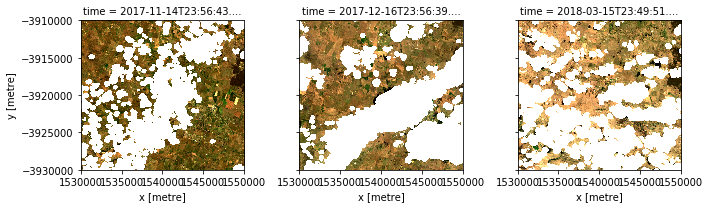

In [17]:
check = lsdata.clean.groupby('time').mean()<0.6
RGB_bands=['red','green','blue']
lsdata[RGB_bands].where(lsdata.clean).isel(time=check).to_array().plot.imshow(col='time',col_wrap=4, robust=True)

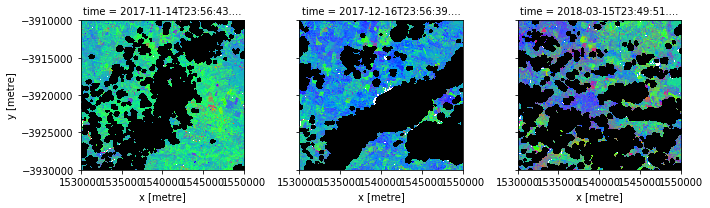

In [18]:
RGB_bands=['BS','PV','NPV']
fc_new.where(fc_new.UE<25)[RGB_bands].isel(time=check).to_array().plot.imshow(col='time',col_wrap=4, robust=True)

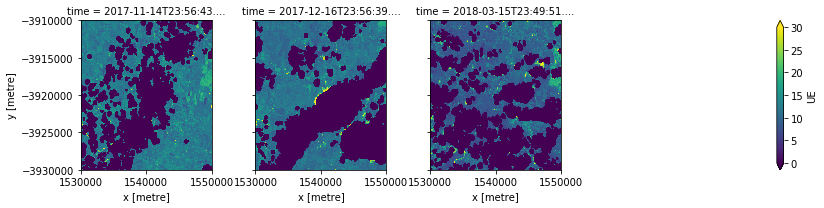

In [19]:
fc_new.UE.isel(time=check).plot.imshow(col='time',col_wrap=4, vmin=0, vmax=30)

(array([1.85618e+05, 2.48637e+05, 1.01800e+04, 3.04000e+02, 1.02000e+02,
        3.80000e+01, 6.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-1. ,  8.5, 18. , 27.5, 37. , 46.5, 56. , 65.5, 75. , 84.5, 94. ]),
 <a list of 10 Patch objects>)

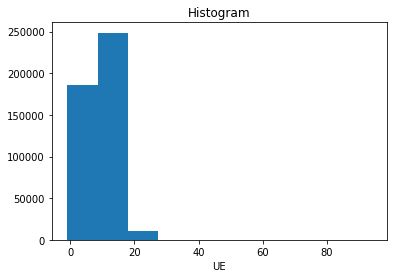

In [20]:
fc_new.UE.isel(time=check).isel(time=0).plot.hist()

Band:BS, slope=1.0357941934245558, r2=0.7565398239201379
Correlations: 0.8802575622372305 0.8703760860933374 0.7351992727965945
RMSE: 4.082564727681854
Band:PV, slope=1.0190947476342913, r2=0.9153298759325615
Correlations: 0.9693593009261104 0.9694190229189618 0.8749989554982538
RMSE: 4.846570825276347
Band:NPV, slope=0.9200690685689669, r2=0.9086458696179871
Correlations: 0.9571707038088142 0.956480432746611 0.8471819094681424
RMSE: 5.809235467950652


[4.082564727681854, 4.846570825276347, 5.809235467950652]

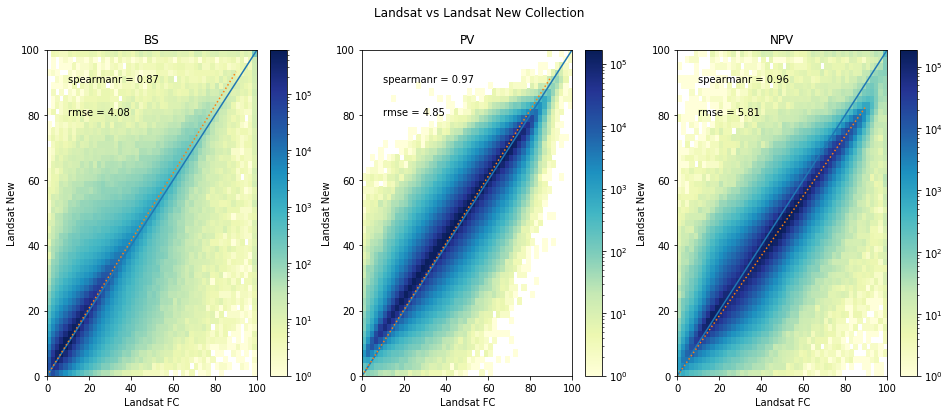

In [21]:
compare_fc_combined(fcdata, fc_new, title='Landsat vs Landsat New Collection')

# resample

In [22]:
fcdata_resampled = downsample_fc(fcdata,factor=5)
fc_new_resampled = downsample_fc(fc_new,factor=5)

Band:BS, slope=1.0669577158379995, r2=0.9389789366075338
Correlations: 0.9704151073411086 0.9652661912820687 0.8470050112225453
RMSE: 1.9644814345166302
Band:PV, slope=1.0238510599928587, r2=0.9742383179735571
Correlations: 0.9961557739601563 0.9963087240738434 0.9543670956661806
RMSE: 2.6927344959827173
Band:NPV, slope=0.9247158341086574, r2=0.976970957389498
Correlations: 0.9906483734668097 0.990263408753596 0.91974331975312
RMSE: 3.9540115555304483


[1.9644814345166302, 2.6927344959827173, 3.9540115555304483]

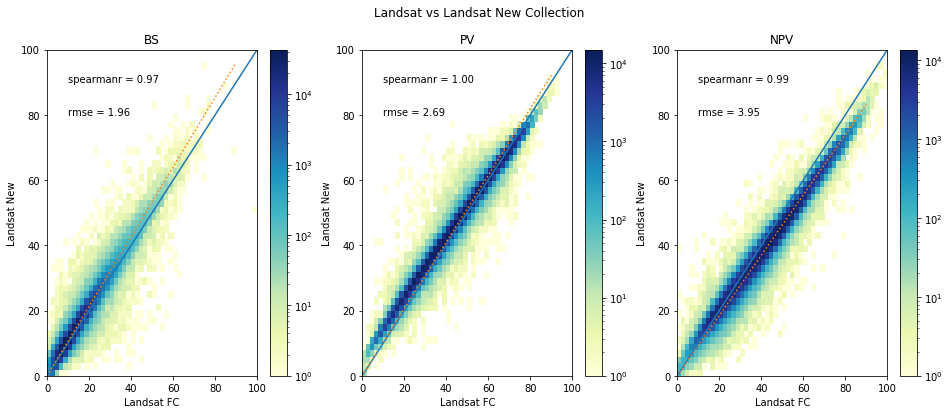

In [23]:
compare_fc_combined(fcdata_resampled, fc_new_resampled, title='Landsat vs Landsat New Collection')

## Plotting examples

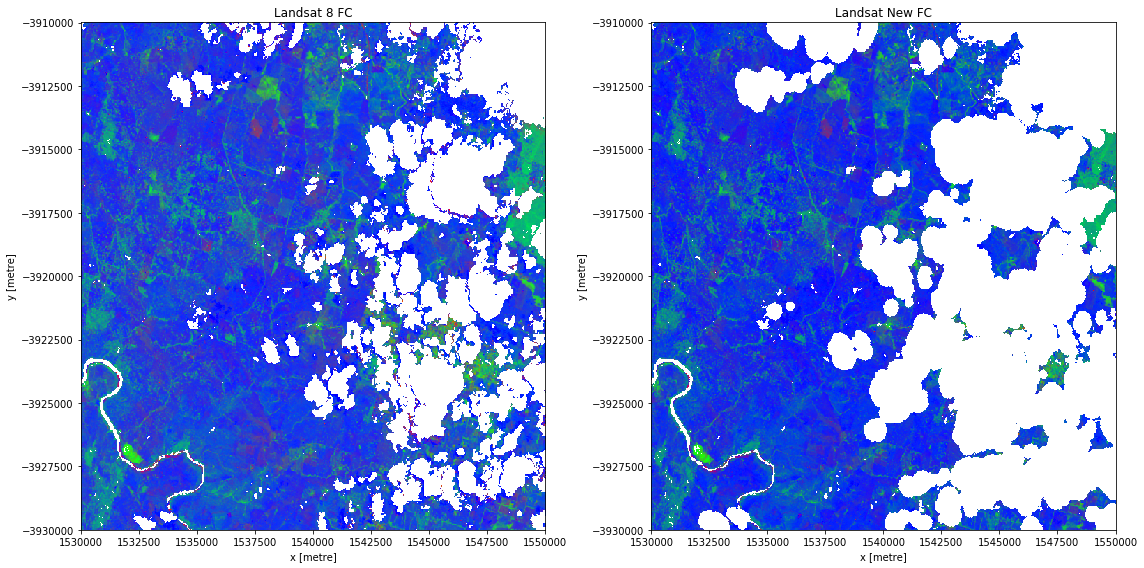

In [24]:
plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1,2) # set up a 2 x 2 grid of 4 images for better presentation

RGB_bands=['BS','PV','NPV']
scene=1
ax1=plt.subplot(gs[0])
fcdata.where(fcdata.UE<20)[RGB_bands].isel(time=scene).to_array().plot.imshow(robust=True, ax=ax1)
ax1.set_title('Landsat 8 FC')

ax2=plt.subplot(gs[1])
fc_new.where(fc_new.UE<20).where(fc_new.UE>0)[RGB_bands].isel(time=scene).to_array().plot.imshow(robust=True, ax=ax2)
ax2.set_title('Landsat New FC')

plt.tight_layout()
plt.show()


## Notes

1. More areas are masked out (cloud buffer)
2. Less problem around cloud
3. UE ~25 filters out shadow - check water and snow